<a href="https://colab.research.google.com/github/Nidhi-S-Vas/Assignment-case_studies/blob/main/Assignment_on_Deep_Learning_for_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Assignment on Deep Learning for NLP

# Step 1: Import libraries

In [89]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional # Import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Step 2: Load your Excel file

In [90]:
data = pd.read_csv('/content/judge-1377884607_tweet_product_company.csv', encoding='ISO-8859-1')


In [91]:
data.head(3)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion


In [92]:

data = data.drop(columns=['emotion_in_tweet_is_directed_at'])

In [93]:
data

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion
...,...,...
9088,Ipad everywhere. #SXSW {link},Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,No emotion toward brand or product


# Step 3: Clean the text

In [94]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

data['clean_text'] = data['tweet_text'].apply(clean_text)

# Step 4: Encode the sentiment labels

In [95]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['is_there_an_emotion_directed_at_a_brand_or_product'])


# Step 5: Check class imbalance



Class Distribution:
is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64


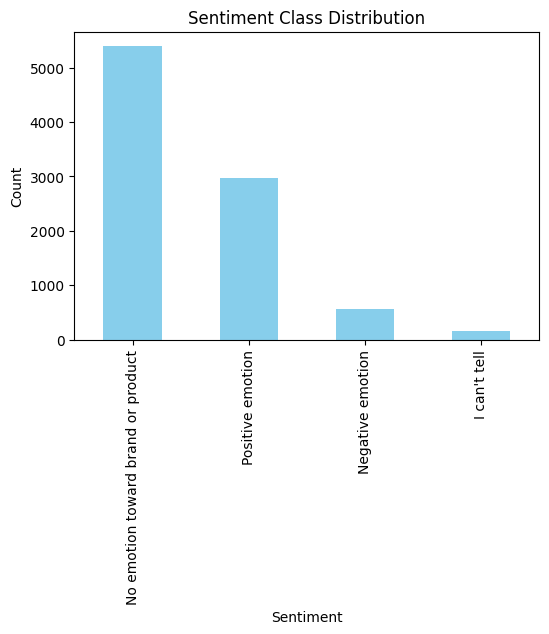

In [96]:
print("\nClass Distribution:")
print(data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts())

plt.figure(figsize=(6,4))
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Step 6: Split the data

In [97]:

X_train, X_test, y_train, y_test = train_test_split(
    data['clean_text'], data['label'], test_size=0.2, random_state=42
)

# Step 7: Tokenize and pad sequences

In [98]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 50
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


# Step 8: Handle Class Imbalance with Class Weights

In [99]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("\nClass Weights:", class_weights)


Class Weights: {0: np.float64(14.665322580645162), 1: np.float64(3.9967032967032967), 2: np.float64(0.4223176962378077), 3: np.float64(0.7611971536207618)}


# Step 9: Build LSTM model


In [100]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=max_len),
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),   # Bidirectional LSTM
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Step 10: Add Early Stopping & Train

In [101]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=64,
    class_weight=class_weights,  # balance classes
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 44s 388ms/step - accuracy: 0.2122 - loss: 1.4126 - val_accuracy: 0.3808 - val_loss: 1.3732
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 376ms/step - accuracy: 0.3986 - loss: 1.2712 - val_accuracy: 0.4914 - val_loss: 1.1850
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 35s 390ms/step - accuracy: 0.5547 - loss: 1.0462 - val_accuracy: 0.5155 - val_loss: 1.1608
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.6633 - loss: 0.8457 - val_accuracy: 0.4969 - val_loss: 1.1193
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 388ms/step - accuracy: 0.7153 - loss: 0.6496 - val_accuracy: 0.5993 - val_loss: 1.0040
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 34s 370ms/step - accuracy: 0.7866 - loss: 0.4962 - val_accuracy: 0.6158 - val_loss: 1.0460
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 41s 370ms/step - accuracy: 0.8139 - loss: 0.3712 - val_accuracy: 0.6165 - val_loss: 1.0576


# Step 11: Evaluate Model

In [102]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

print("\nAccuracy:", accuracy_score(y_test, y_pred_classes))
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes, target_names=le.classes_))

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step

Accuracy: 0.5711929631665751

Classification Report:
                                     precision    recall  f1-score   support

                      I can't tell       0.03      0.19      0.05        32
                  Negative emotion       0.37      0.42      0.39       115
No emotion toward brand or product       0.73      0.62      0.67      1083
                  Positive emotion       0.55      0.54      0.54       589

                          accuracy                           0.57      1819
                         macro avg       0.42      0.44      0.41      1819
                      weighted avg       0.63      0.57      0.60      1819



# Step 12: Plot Training Accuracy & Loss

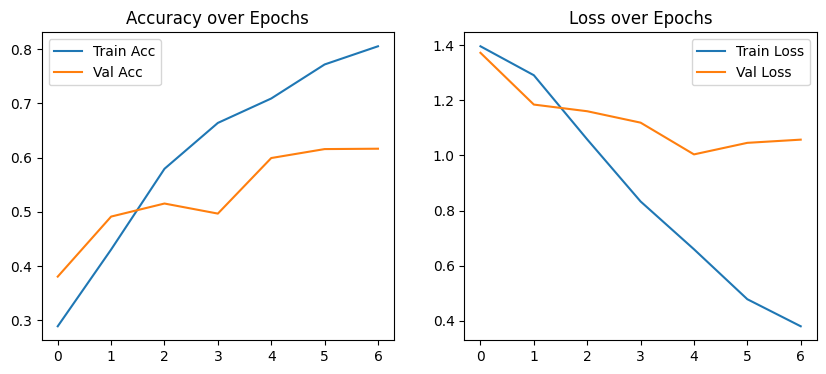

In [103]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

#Predicting on unseen data

In [104]:
# Example unseen tweet(s)
new_tweets = [
    "I love how fast the service was!",
    "The product was disappointing and cheap.",
    "Can't say anything about it.",
    "This brand makes me feel great."
]

# Clean the text (same function as before)
new_tweets_clean = [clean_text(t) for t in new_tweets]

# Tokenize and pad
new_seq = tokenizer.texts_to_sequences(new_tweets_clean)
new_pad = pad_sequences(new_seq, maxlen=max_len, padding='post')

# Predict
pred = model.predict(new_pad)
pred_classes = np.argmax(pred, axis=1)

# Convert back to labels
predicted_labels = le.inverse_transform(pred_classes)

# Show results
for t, l in zip(new_tweets, predicted_labels):
    print(f"Tweet: {t}\nPredicted Emotion: {l}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Tweet: I love how fast the service was!
Predicted Emotion: Positive emotion

Tweet: The product was disappointing and cheap.
Predicted Emotion: Negative emotion

Tweet: Can't say anything about it.
Predicted Emotion: No emotion toward brand or product

Tweet: This brand makes me feel great.
Predicted Emotion: Positive emotion



The LSTM model achieved an overall accuracy of about 57 percent after applying class weighting to address the data imbalance. The model showed better recognition across different emotion categories and was able to correctly predict sentiments for unseen tweets, indicating that it can generalize to new data. With further tuning, such as increasing training epochs or adjusting model parameters, the performance can be improved further.